In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_

In [5]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

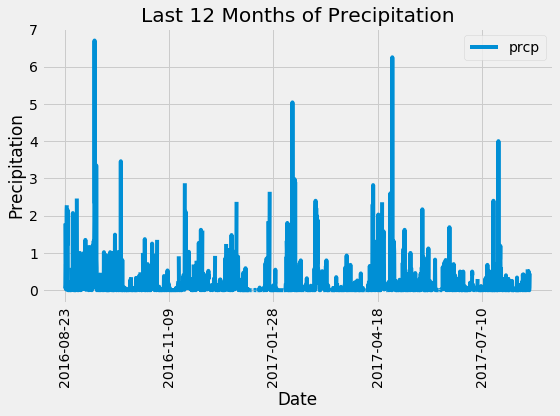

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date 1 year ago from the last data point in the database
first_date = (pd.to_datetime(last_date) + pd.DateOffset(months=-12)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data).set_index('date')

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(title='Last 12 Months of Precipitation', rot=90, figsize=(8, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.tight_layout()
plt.savefig('images/12months-precipitation.png', dpi=200)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).\
    all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

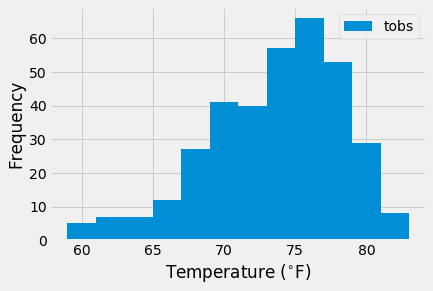

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observe = pd.DataFrame(session.query(Measurement.tobs)\
                    .filter(Measurement.station == most_active[0][0])\
                    .filter(Measurement.date >= first_date).all())
observe.plot(kind='hist', bins=12)
plt.xlabel(r'Temperature ($^{\circ}$F)')
plt.savefig('images/most-active-histogram.png', dpi=200)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps('2017-02-28', '2017-03-05')[0]
calc_temps('2017-02-28', '2017-03-05')

[(64.0, 72.02777777777777, 78.0)]

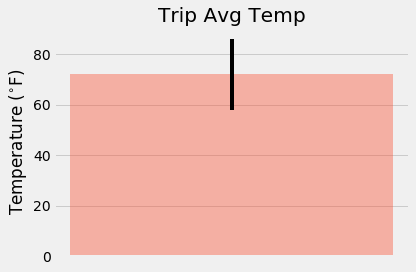

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar('', height=tavg, yerr=tmax - tmin, color='C1', alpha=0.4)
plt.ylabel(r'Temperature ($^{\circ}$F)')
plt.title('Trip Avg Temp')
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('images/trip-avg-temp.png', dpi=200)

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rain = session.query(Measurement.station,
              Station.name,
              Station.latitude,
              Station.longitude,
              Station.elevation,
              func.sum(Measurement.prcp).label('Total Rain')
             ).\
    group_by(Measurement.station).\
    filter(Measurement.station == Station.station).\
    filter(and_(Measurement.date >= dt.datetime(2017, 2, 28)), Measurement.date <= dt.datetime(2017, 3, 5)).\
    order_by(func.sum(Measurement.prcp).desc()).all()
pd.DataFrame(total_rain)

,station,name,latitude,longitude,elevation,Total Rain
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.68
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.29
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.49
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.98
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.74
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.32
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.12


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime(2017, 2, 28)
end_date = dt.datetime(2017, 3, 5)

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date, freq='D')

# Stip off the year and save a list of %m-%d strings
list_dates = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(d)[0] for d in list_dates]
normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_trip = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=date_range)
df_trip.index.name = 'Date'
df_trip

,tmin,tavg,tmax
Date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


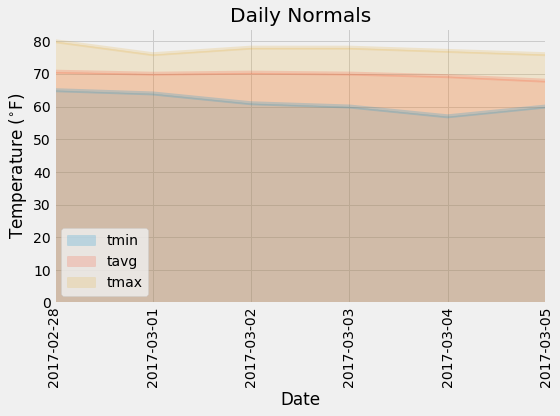

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
df_trip.plot.area(stacked=False, alpha=0.2, rot=90, figsize=(8, 6))
plt.xticks(date_range.strftime('%Y-%m-%d'), date_range.strftime('%Y-%m-%d'))
plt.title('Daily Normals')
plt.ylabel(r'Temperature ($^{\circ}$F)')
plt.tight_layout()
plt.savefig('images/daily-normals.png', dpi=200)